In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
from PIL import Image, ImageDraw, ImageEnhance, ImageFont

In [13]:
def normalize_image(image):
    image = image.astype(np.float32)
    image -= image.min()
    image /= image.max()
    image *= 255.0
    return image.astype(np.uint8)


# make the composite images
def make_composite_image(
    image1_path: pathlib.Path,  # yellow
    image2_path: pathlib.Path,  # green
    image3_path: pathlib.Path,  # red
    image4_path: pathlib.Path,  # blue
):
    # Load the images
    image1 = tifffile.imread(image1_path)
    image2 = tifffile.imread(image2_path)
    image3 = tifffile.imread(image3_path)
    image4 = tifffile.imread(image4_path)

    # Normalize the images to the range [0, 255]
    image1 = normalize_image(image1)  # 488_1
    image2 = normalize_image(image2)  # 488_2
    image3 = normalize_image(image3)  # 561
    image4 = normalize_image(image4)  # DNA
    # make a cyan, magenta, yellow composite
    # cyan = green + blue
    # magenta = red + blue
    # yellow = red + green
    # composite = max(cyan, magenta, yellow)
    cyan = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
    cyan[..., 1] = image4  # green
    cyan[..., 2] = image4  # blue
    magenta = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
    magenta[..., 0] = image3  # red
    magenta[..., 2] = image3  # blue
    yellow = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)
    yellow[..., 0] = image1  # red
    yellow[..., 1] = image1  # green
    composite = np.maximum(cyan, np.maximum(magenta, yellow))
    # Convert to PIL Image for enhancement
    composite = Image.fromarray(composite)
    enhancer = ImageEnhance.Contrast(composite)
    composite = enhancer.enhance(2)  # Increase contrast
    enhancer = ImageEnhance.Brightness(composite)
    composite = enhancer.enhance(1.5)  # Increase brightness
    return composite


# scale the images up for better visualization
def scale_image(image, scale_factor=4):
    width, height = image.size
    new_size = (int(width * scale_factor), int(height * scale_factor))
    return image.resize(new_size, Image.NEAREST)

In [14]:
umap_file_path = pathlib.Path(
    "../../3.generate_umap_and_PCA/results/UMAP/single-cell_profiles_CP_scDINO_umap.parquet"
).resolve(strict=True)
umap_df = pd.read_parquet(umap_file_path)
# make the time column numeric
umap_df["Metadata_Time"] = pd.to_numeric(umap_df["Metadata_Time"])
umap_df["Metadata_Time"] = umap_df["Metadata_Time"].astype(int)
umap_df["Metadata_Time"] = umap_df["Metadata_Time"] * 30
umap_df["Metadata_Well_FOV"] = (
    umap_df["Metadata_Well"].astype(str) + "_" + umap_df["Metadata_FOV"].astype(str)
)

In [15]:
# get a random Metadata_track_id for a few wells
well_fovs = umap_df["Metadata_Well_FOV"].unique()
# for each well we will find a Metadata_track_id that has
# all time points
track_ids = {"well_fovs": [], "track_id": []}
np.random.seed(1)
for well_fov in well_fovs:
    well_df = umap_df[umap_df["Metadata_Well_FOV"] == well_fov]
    track_id_counts = well_df["Metadata_track_id"].value_counts()
    # find a track id that has all time points (48)
    full_track_ids = track_id_counts[track_id_counts == 13].index.tolist()
    if len(full_track_ids) > 0:
        track_ids["well_fovs"].append(well_fov)
        track_ids["track_id"].append(np.random.choice(full_track_ids))

In [16]:
df = pd.DataFrame(track_ids)
df = df.sort_values(by="well_fovs")
# get all values from umap_df that match the well and track_id
montage_df = pd.DataFrame()
for index, row in df.iterrows():
    well_fov = row["well_fovs"]
    track_id = row["track_id"]
    temp_df = umap_df[
        (umap_df["Metadata_Well_FOV"] == well_fov)
        & (umap_df["Metadata_track_id"] == track_id)
    ]
    montage_df = pd.concat([montage_df, temp_df])
montage_df = montage_df.reset_index(drop=True)
montage_df.head()

,UMAP_0,UMAP_1,Metadata_plate,Metadata_Well,Metadata_number_of_singlecells,Metadata_compound,Metadata_dose,Metadata_control,Metadata_ImageNumber,Metadata_FOV,...,Metadata_distance,Metadata_original_index,Metadata_image_path,Metadata_Cells_AreaShape_BoundingBoxArea_CP,Metadata_Image_FileName_CL_488_1_crop,Metadata_Image_FileName_CL_488_2_crop,Metadata_Image_FileName_CL_561_crop,Metadata_Image_FileName_DNA_crop,Metadata_parent_path,Metadata_Well_FOV
0,1.584772,7.945917,1,C-02,177,Staurosporine,0.0,negative,1,0001,...,0.638558,111257,../0.pre-process_images/data/processed_images/...,-0.967486,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,C-02_0001
1,1.438981,8.348973,1,C-02,169,Staurosporine,0.0,negative,3,0001,...,0.442833,111354,../0.pre-process_images/data/processed_images/...,-0.605110,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,C-02_0001
2,1.130028,8.126949,1,C-02,169,Staurosporine,0.0,negative,4,0001,...,0.488990,111496,../0.pre-process_images/data/processed_images/...,-0.134669,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,C-02_0001
3,0.427295,8.006639,1,C-02,174,Staurosporine,0.0,negative,5,0001,...,0.112463,111639,../0.pre-process_images/data/processed_images/...,0.543631,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,C-02_0001
4,-0.487417,8.045197,1,C-02,173,Staurosporine,0.0,negative,6,0001,...,0.536743,111776,../0.pre-process_images/data/processed_images/...,1.293185,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,/home/lippincm/4TB_A/live_cell_timelapse_apopt...,C-02_0001


In [17]:
dict_of_composite_images_control = {
    "single_cell_id": [],
    "well": [],
    "composite": [],
    "time": [],
}

In [18]:
for index, row in montage_df.loc[
    (montage_df["Metadata_Well_FOV"] == "C-02_0001")
].iterrows():
    well_fov = row["Metadata_Well_FOV"]
    time = row["Metadata_Time"]
    single_cell_id = row["Metadata_track_id"]
    image1_path = pathlib.Path(row["Metadata_Image_FileName_CL_488_1_crop"]).resolve(
        strict=True
    )
    image2_path = pathlib.Path(row["Metadata_Image_FileName_CL_488_2_crop"]).resolve(
        strict=True
    )
    image3_path = pathlib.Path(row["Metadata_Image_FileName_CL_561_crop"]).resolve(
        strict=True
    )
    image4_path = pathlib.Path(row["Metadata_Image_FileName_DNA_crop"]).resolve(
        strict=True
    )
    composite_image = make_composite_image(
        image1_path=image1_path,
        image2_path=image2_path,
        image3_path=image3_path,
        image4_path=image4_path,
    )
    dict_of_composite_images_control["single_cell_id"].append(single_cell_id)
    dict_of_composite_images_control["well"].append(well_fov)
    dict_of_composite_images_control["composite"].append(composite_image)
    dict_of_composite_images_control["time"].append(time)
dict_of_composite_images_control
composite_control_df = pd.DataFrame(dict_of_composite_images_control)
# sort by time
composite_control_df = composite_control_df.sort_values(by="time")
composite_control_df.reset_index(drop=True, inplace=True)

In [20]:
def generate_image_pannel_df(well_fov, cell_id):
    output_dict = {
        "single_cell_id": [],
        "well_fov": [],
        "composite": [],
        "time": [],
        "dose": [],
    }
    try:
        for index, row in montage_df.loc[
            (montage_df["Metadata_Well_FOV"] == well_fov)
            & (montage_df["Metadata_track_id"] == cell_id)
        ].iterrows():
            well_fov = row["Metadata_Well_FOV"]
            time = row["Metadata_Time"]
            single_cell_id = row["Metadata_track_id"]
            image1_path = pathlib.Path(
                row["Metadata_Image_FileName_CL_488_1_crop"]
            ).resolve(strict=True)
            image2_path = pathlib.Path(
                row["Metadata_Image_FileName_CL_488_2_crop"]
            ).resolve(strict=True)
            image3_path = pathlib.Path(
                row["Metadata_Image_FileName_CL_561_crop"]
            ).resolve(strict=True)
            image4_path = pathlib.Path(row["Metadata_Image_FileName_DNA_crop"]).resolve(
                strict=True
            )
            composite_image = scale_image(
                make_composite_image(
                    image1_path=image1_path,
                    image2_path=image2_path,
                    image3_path=image3_path,
                    image4_path=image4_path,
                )
            )
            output_dict["single_cell_id"].append(single_cell_id)
            output_dict["well_fov"].append(well_fov)
            output_dict["composite"].append(composite_image)
            output_dict["time"].append(time)
            output_dict["dose"].append(row["Metadata_dose"])
    except Exception as e:
        print(f"Error processing well_fov {well_fov}: {e}")
    output_df = pd.DataFrame(output_dict)
    # sort by time
    output_df = output_df.sort_values(by="time")
    output_df.reset_index(drop=True, inplace=True)
    return output_df

In [21]:
c02_df = generate_image_pannel_df("C-02_0001", 23)
c03_df = generate_image_pannel_df("C-03_0001", 25)
c04_df = generate_image_pannel_df("C-04_0001", 8)
c05_df = generate_image_pannel_df("C-05_0001", 44)
c06_df = generate_image_pannel_df("C-06_0001", 106)
c07_df = generate_image_pannel_df("C-07_0001", 62)
c08_df = generate_image_pannel_df("C-08_0001", 77)
c09_df = generate_image_pannel_df("C-09_0001", 22)
c10_df = generate_image_pannel_df("C-10_0001", 101)
c11_df = generate_image_pannel_df("C-11_0001", 141)

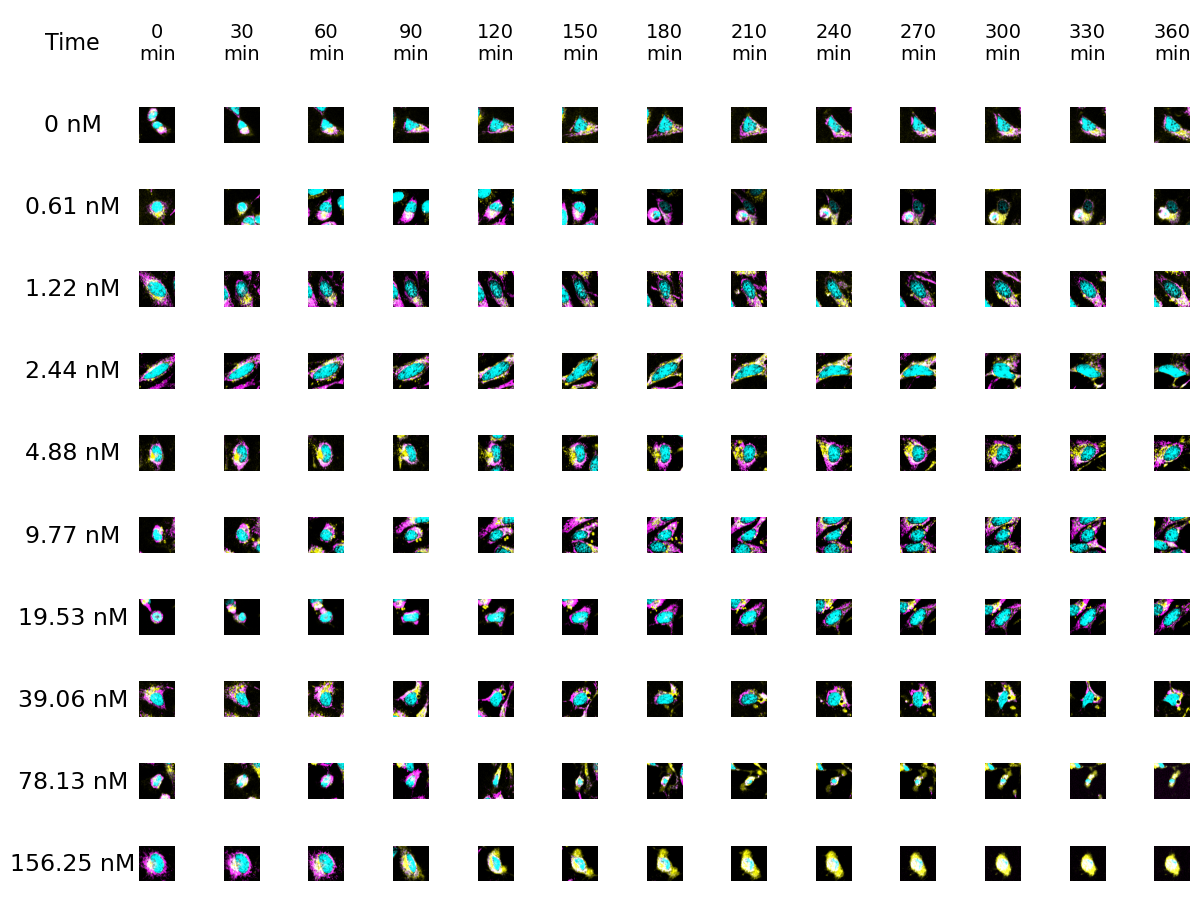

In [27]:
# create a montage of the images in composite_df
plt.figure(figsize=(12, 10))

for index, row in composite_control_df.iterrows():
    if index == 0:
        plt.subplot(12, len(composite_control_df) + 1, index + 1)
        plt.text(0.5, 0.5, "Time", fontsize=16, ha="center", va="center")
        plt.axis("off")
        plt.subplot(12, len(composite_control_df) + 1, index + 2)
        plt.text(0.5, 0.5, f"{row['time']}\nmin", fontsize=14, ha="center", va="center")
        plt.axis("off")
    else:
        plt.subplot(12, len(composite_control_df) + 1, index + 2)
        plt.text(0.5, 0.5, f"{row['time']}\nmin", fontsize=14, ha="center", va="center")
        plt.axis("off")
for index, row in composite_control_df.iterrows():
    if index == 0:
        plt.subplot(
            12, len(composite_control_df) + 1, index + len(composite_control_df) + 2
        )
        plt.text(0.5, 0.5, "0 nM", fontsize=16 + 1, ha="center", va="center")
        plt.axis("off")
        plt.subplot(
            12, len(composite_control_df) + 1, index + len(composite_control_df) + 3
        )
        plt.imshow(row["composite"])
    else:
        plt.subplot(
            12, len(composite_control_df) + 1, index + len(composite_control_df) + 3
        )
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c03_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c03_df) + 1, index + 2 * len(c03_df) + 3)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c03_df) + 1, index + 2 * len(c03_df) + 4)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c03_df) + 1, index + 2 * len(c03_df) + 4)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c04_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c04_df) + 1, index + 3 * len(c04_df) + 4)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c04_df) + 1, index + 3 * len(c04_df) + 5)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c04_df) + 1, index + 3 * len(c04_df) + 5)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c05_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c05_df) + 1, index + 4 * len(c05_df) + 5)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c05_df) + 1, index + 4 * len(c05_df) + 6)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c05_df) + 1, index + 4 * len(c05_df) + 6)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c06_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c06_df) + 1, index + 5 * len(c06_df) + 6)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c06_df) + 1, index + 5 * len(c06_df) + 7)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c06_df) + 1, index + 5 * len(c06_df) + 7)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c07_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c07_df) + 1, index + 6 * len(c07_df) + 7)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c07_df) + 1, index + 6 * len(c07_df) + 8)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c07_df) + 1, index + 6 * len(c07_df) + 8)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c08_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c08_df) + 1, index + 7 * len(c08_df) + 8)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c08_df) + 1, index + 7 * len(c08_df) + 9)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c08_df) + 1, index + 7 * len(c08_df) + 9)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c09_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c09_df) + 1, index + 8 * len(c09_df) + 9)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c09_df) + 1, index + 8 * len(c09_df) + 10)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c09_df) + 1, index + 8 * len(c09_df) + 10)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c10_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c10_df) + 1, index + 9 * len(c10_df) + 10)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c10_df) + 1, index + 9 * len(c10_df) + 11)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c10_df) + 1, index + 9 * len(c10_df) + 11)
        plt.imshow(row["composite"])
    plt.axis("off")
for index, row in c11_df.iterrows():
    if index == 0:
        plt.subplot(12, len(c11_df) + 1, index + 10 * len(c11_df) + 11)
        plt.text(
            0.5, 0.5, f"{row['dose']} nM", fontsize=16 + 1, ha="center", va="center"
        )
        plt.axis("off")
        plt.subplot(12, len(c11_df) + 1, index + 10 * len(c11_df) + 12)
        plt.imshow(row["composite"])
    else:
        plt.subplot(12, len(c11_df) + 1, index + 10 * len(c11_df) + 12)
        plt.imshow(row["composite"])
    plt.axis("off")
plt.tight_layout()
plt.show()